# **Aprendizado de Máquina: Transfer Learning**

> Este Notebook apresenta um projeto de Transfer Learning, utilizando a rede ResNet e VGG. Para fins de ilustração, trabalharemos com o conjunto de dados [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), disponível no Kaggle.

## Introdução

### **Contextualização do Dataset:**

- O dataset Intel Image Classification é composto por imagens de diferentes tipos de cenários (construções, florestas, geleiras, montanhas, mar, ruas, etc.). Geralmente, ele está organizado em pastas de treino e teste, cada qual segmentada em subpastas, onde cada subpasta representa uma categoria (por exemplo: buildings, forest, glacier, mountain, sea, street).


- É um conjunto de dados interessante para demonstrar técnicas de Transfer Learning, pois possui imagens de diferentes cenários, é relativamente simples de baixar e, ao mesmo tempo, oferece uma boa variedade de exemplos.

### **Visão Geral do Fluxo**


1. Carregar e organizar o dataset (Intel Image Classification).

2. Definir transformações, DataLoaders (concluído na parte anterior).

3. Escolher e inicializar dois modelos pré-treinados diferentes (ResNet18 e VGG16).

4. Treinar e validar cada modelo, registrando o melhor resultado obtido em validação.

5. Avaliar o melhor modelo de cada arquitetura no conjunto de teste.

6. Comparar os resultados de ResNet18 vs. VGG16.

## 1. Download do Dataset

In [1]:
# Instale a biblioteca kaggle se necessário
!pip install kaggle --upgrade

# Exemplo de comandos para baixar o dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Descompacta o arquivo zip baixado
!unzip -q intel-image-classification.zip -d intel-image-classification


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 98% 338M/346M [00:07<00:00, 38.8MB/s]
100% 346M/346M [00:07<00:00, 51.0MB/s]


## 2. Importação das Bibliotecas



In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

# Versão do PyTorch
print("Versão do PyTorch:", torch.__version__)

# Verifica dispositivo disponível (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo em uso:", device)


Versão do PyTorch: 2.5.1+cu124
Dispositivo em uso: cuda


- os, shutil, numpy, matplotlib: Para manipulação de diretórios, operações de sistema e visualização de dados.

- PyTorch (torch, nn, optim): Biblioteca principal para construção e treinamento de redes neurais.

- torchvision (transforms, datasets, models): Conjunto de utilitários para visão computacional, contendo transformações, datasets e modelos pré-treinados.

## 3. Organização do Dataset

> O dataset original contém pastas para treino (seg_train) e teste (seg_test), mas não necessariamente uma pasta de validação pronta. Assim, podemos criar uma pasta seg_val movendo uma pequena porcentagem das imagens de treino para servir como conjunto de validação.

In [3]:
# Diretório base onde o dataset foi descompactado
base_dir = "intel-image-classification"

# Caminhos para treino e teste
train_dir = os.path.join(base_dir, "seg_train", "seg_train")
test_dir  = os.path.join(base_dir, "seg_test",  "seg_test")

# Cria diretório para validação, caso não exista
val_dir   = os.path.join(base_dir, "seg_val")
if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)

    # Vamos separar 10% das imagens de cada classe para validação
    for class_folder in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_folder)

        # Se for uma pasta de classe
        if os.path.isdir(class_path):
            val_class_path = os.path.join(val_dir, class_folder)
            os.makedirs(val_class_path, exist_ok=True)

            # Lista de imagens da classe e embaralha
            images = os.listdir(class_path)
            np.random.shuffle(images)

            # 10% dos dados para validação
            val_size = int(0.1 * len(images))
            val_images = images[:val_size]

            # Mover arquivos para a pasta de validação
            for img in val_images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(val_class_path, img)
                shutil.move(src_path, dst_path)

print("Arquivos em treino:", os.listdir(train_dir))
print("Arquivos em validação:", os.listdir(val_dir))
print("Arquivos em teste:", os.listdir(test_dir))


Arquivos em treino: ['sea', 'street', 'forest', 'buildings', 'glacier', 'mountain']
Arquivos em validação: ['sea', 'street', 'forest', 'buildings', 'glacier', 'mountain']
Arquivos em teste: ['sea', 'street', 'forest', 'buildings', 'glacier', 'mountain']


## 4. Definindo as transformações


> Para Transfer Learning, geralmente redimensionamos para (224, 224) e normalizamos com estatísticas do ImageNet. Também aplicamos algumas técnicas de Data Augmentation no conjunto de treino (por exemplo, RandomHorizontalFlip).

In [4]:
# Transformações de treino (com data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformações de validação e teste (sem augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## 5. Criando Datasets e DataLoaders


In [5]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=val_dir,   transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=val_test_transforms)

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Tamanho do dataset de treino: {len(train_dataset)}")
print(f"Tamanho do dataset de validação: {len(val_dataset)}")
print(f"Tamanho do dataset de teste: {len(test_dataset)}")

class_names = train_dataset.classes
print("Classes:", class_names)


Tamanho do dataset de treino: 12632
Tamanho do dataset de validação: 1402
Tamanho do dataset de teste: 3000
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## 6. Visualizando algumas imagens


> Sempre é bom conferir se o DataLoader está funcionando conforme esperado.



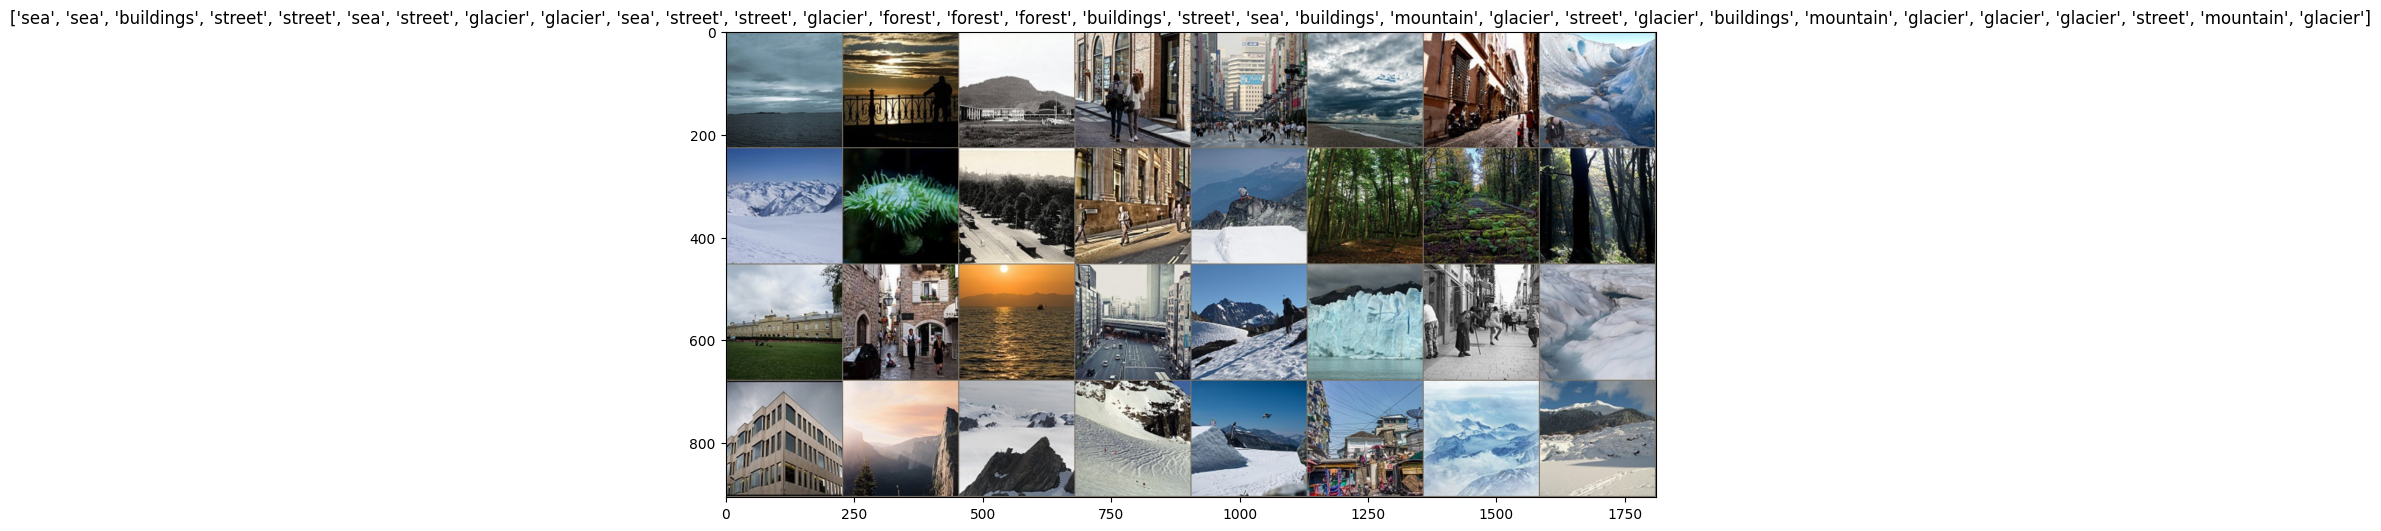

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Pegando um batch do train_loader
inputs, labels = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(12, 8))
imshow(out, title=[class_names[x] for x in labels])
plt.show()


## 7. Configurando Modelos Pré-Treinados

> Para comparar, vamos criar duas funções utilitárias para carregar cada arquitetura:

```
create_resnet18(num_classes=6)
```

```
create_vgg16(num_classes=6)
```

Ambas irão:

- Baixar o modelo pré-treinado (ImageNet).
- Congelar as camadas iniciais.
- Trocar a camada final (cabeça da rede) para o número de classes do Intel Image Classification.
-Retornar o modelo configurado.



In [7]:
import torch
import torch.nn as nn
from torchvision import models

def create_resnet18(num_classes=6):
    """
    Cria e retorna um modelo ResNet18 pré-treinado no ImageNet,
    com a última camada ajustada para 'num_classes'.
    """
    model = models.resnet18(pretrained=True)
    # Congelar parâmetros
    for param in model.parameters():
        param.requires_grad = False
    # Ajustar camada final
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def create_vgg16(num_classes=6):
    """
    Cria e retorna um modelo VGG16 pré-treinado no ImageNet,
    com a última camada ajustada para 'num_classes'.
    """
    model = models.vgg16(pretrained=True)
    # Congelar parâmetros das camadas convolucionais
    for param in model.features.parameters():
        param.requires_grad = False

    # A camada final do VGG16 é model.classifier
    # Ela geralmente tem 4096 -> 4096 -> 1000, etc. Precisamos ajustar a última para 'num_classes'
    # VGG16 "classic" tem algo como (Linear(25088, 4096), ReLU, Dropout, Linear(4096, 4096), ReLU, Dropout, Linear(4096, 1000))

    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model


### 7.2. Definindo Função Geral de Treinamento e Validação

> Vamos utilizar a mesma função de treinamento e validação para ambos os modelos. Assim, temos consistência na forma de medir desempenho (loss e accuracy).

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=5, model_name="model"):
    """
    Função para treinar e validar o modelo.

    Parâmetros:
    - model: modelo PyTorch (por exemplo, ResNet18 ou VGG16)
    - criterion: função de perda (CrossEntropyLoss)
    - optimizer: otimizador (SGD, Adam, etc.)
    - train_loader: DataLoader do conjunto de treinamento
    - val_loader: DataLoader do conjunto de validação
    - device: cuda ou cpu
    - epochs: número de épocas para treinamento
    - model_name: nome do modelo (usado ao salvar o melhor checkpoint)

    Retorna:
    - history: dicionário com o histórico de treino (loss, acc) e validação (loss, acc) por epoch
    """
    best_acc = 0.0
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        print(f"\n\033[1m[{model_name}] Epoch {epoch+1}/{epochs}\033[0m")
        print("-" * 40)

        # ------------------
        # Fase de Treinamento
        # ------------------
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc  = running_corrects.double() / len(train_loader.dataset)

        # ------------------
        # Fase de Validação
        # ------------------
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc  = val_running_corrects.double() / len(val_loader.dataset)

        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Salvar melhor modelo
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            print(f"-> Melhor modelo salvo! Val Acc: {best_acc:.4f}")

        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc.item())
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc.item())

    print(f"\nTreinamento finalizado. Melhor Val Acc: {best_acc:.4f} para {model_name}")
    return history


## 8. Inicializando, Treinando e Validando Ambos os Modelos

In [9]:
# Número de classes do dataset (Intel: 6 classes)
num_classes = len(train_dataset.classes)

resnet_model = create_resnet18(num_classes=num_classes).to(device)
vgg_model    = create_vgg16(num_classes=num_classes).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.3MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

### 8.1 Definindo Função de Perda e Otimizador

> Podemos usar a função de perda (CrossEntropyLoss) e, por exemplo, um SGD com mesma taxa de aprendizado para ambos:

In [10]:
criterion = nn.CrossEntropyLoss()

# Otimizador para ResNet18 (note que apenas a última camada está "requires_grad = True")
resnet_optimizer = torch.optim.SGD(resnet_model.fc.parameters(), lr=0.001, momentum=0.9)

# Otimizador para VGG16 (a última camada do classifier é "requires_grad = True")
vgg_optimizer    = torch.optim.SGD(vgg_model.classifier[6].parameters(), lr=0.001, momentum=0.9)


### 8.2. Treino

> Podemos, então, chamar train_model() para cada um separadamente, definindo o número de épocas igual a 5.

In [11]:
epochs = 5

resnet_history = train_model(
    model=resnet_model,
    criterion=criterion,
    optimizer=resnet_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=epochs,
    model_name="ResNet18"
)

vgg_history = train_model(
    model=vgg_model,
    criterion=criterion,
    optimizer=vgg_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=epochs,
    model_name="VGG16"
)



[ResNet18] Epoch 1/5
----------------------------------------
Train Loss: 0.5396 Acc: 0.8268 | Val Loss: 0.3203 Acc: 0.8930
-> Melhor modelo salvo! Val Acc: 0.8930

[ResNet18] Epoch 2/5
----------------------------------------
Train Loss: 0.3277 Acc: 0.8861 | Val Loss: 0.2874 Acc: 0.8980
-> Melhor modelo salvo! Val Acc: 0.8980

[ResNet18] Epoch 3/5
----------------------------------------
Train Loss: 0.2988 Acc: 0.8966 | Val Loss: 0.2779 Acc: 0.9009
-> Melhor modelo salvo! Val Acc: 0.9009

[ResNet18] Epoch 4/5
----------------------------------------
Train Loss: 0.2860 Acc: 0.8995 | Val Loss: 0.2709 Acc: 0.9044
-> Melhor modelo salvo! Val Acc: 0.9044

[ResNet18] Epoch 5/5
----------------------------------------
Train Loss: 0.2758 Acc: 0.9042 | Val Loss: 0.2666 Acc: 0.9016

Treinamento finalizado. Melhor Val Acc: 0.9044 para ResNet18

[VGG16] Epoch 1/5
----------------------------------------
Train Loss: 0.3723 Acc: 0.8699 | Val Loss: 0.2529 Acc: 0.9108
-> Melhor modelo salvo! Val Acc

> Para cada um, será salvo o melhor modelo em best_ResNet18.pth ou best_VGG16.pth com base na melhor acurácia de validação obtida durante o treinamento.

## 9. Avaliação no Conjunto de Teste

> Ao terminar, podemos carregar o melhor modelo salvo e medir a acurácia no test set. Faremos isso para cada arquitetura.

In [12]:
def evaluate_model(model, checkpoint_path, test_loader, device):
    """
    Carrega um modelo PyTorch a partir de 'checkpoint_path'
    e avalia seu desempenho (acurácia) no 'test_loader'.
    Retorna a acurácia.
    """
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    test_acc = corrects.double() / total
    return test_acc.item()

# Avaliando ResNet18
resnet_test_acc = evaluate_model(resnet_model, "best_ResNet18.pth", test_loader, device)
print(f"Acurácia ResNet18 no Teste: {resnet_test_acc:.4f}")

# Avaliando VGG16
vgg_test_acc = evaluate_model(vgg_model, "best_VGG16.pth", test_loader, device)
print(f"Acurácia VGG16 no Teste: {vgg_test_acc:.4f}")


<ipython-input-12-0e1f3dc85f3d>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Acurácia ResNet18 no Teste: 0.9043
Acurácia VGG16 no Teste: 0.9187


### Comparando Resultados

### Comparação de Acurácia

In [13]:
print("\nComparação de Acurácia no Conjunto de Teste:")
print(f" - ResNet18: {resnet_test_acc:.4f}")
print(f" - VGG16   : {vgg_test_acc:.4f}")

if resnet_test_acc > vgg_test_acc:
    print("ResNet18 obteve melhor desempenho no teste.")
else:
    print("VGG16 obteve melhor desempenho no teste.")



Comparação de Acurácia no Conjunto de Teste:
 - ResNet18: 0.9043
 - VGG16   : 0.9187
VGG16 obteve melhor desempenho no teste.


### Plot das Curvas de Aprendizado

> Podemos plotar as curvas de treinamento e validação (loss e acc) salvas em resnet_history e vgg_history para compará-las visualmente:

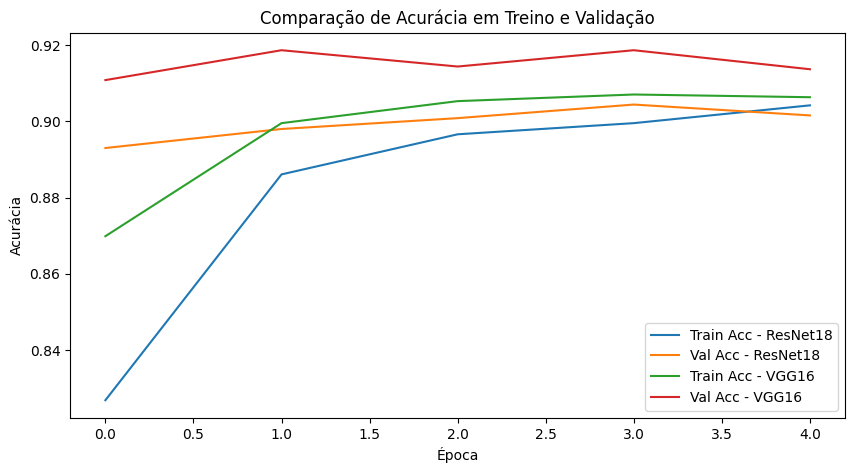

In [14]:
import matplotlib.pyplot as plt

def plot_history(hist, label, epochs):
    x = range(epochs)
    plt.plot(x, hist["train_acc"], label=f"Train Acc - {label}")
    plt.plot(x, hist["val_acc"], label=f"Val Acc - {label}")

epochs_range = range(epochs)
plt.figure(figsize=(10, 5))

# ResNet
plot_history(resnet_history, "ResNet18", epochs)

# VGG
plot_history(vgg_history, "VGG16", epochs)

plt.title("Comparação de Acurácia em Treino e Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.show()


> **Isso ajuda a verificar se ambos os modelos estão aprendendo de forma estável, se há overfitting e qual converge melhor/faster.**

### Matriz de Confusão, Precisão, F1

> Para analisar mais detalhadamente o desempenho em cada classe, podemos coletar as predições e rótulos no teste, gerando uma matriz de confusão e calculando precisão, recall e F1-score:

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [17]:
def evaluate_model_detailed(model, checkpoint_path, test_loader, device):
    """
    Carrega o modelo a partir de 'checkpoint_path' e realiza previsões
    em todo o test_loader para retornar:
      - Acurácia do conjunto de teste
      - all_preds: Lista/array de todas as predições
      - all_labels: Lista/array de todos os rótulos verdadeiros
    """
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    corrects = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

            # Guarda predições e rótulos
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = corrects.double() / total
    return test_acc.item(), all_preds, all_labels


In [18]:
# Avaliando ResNet18 em detalhes
resnet_test_acc, resnet_preds, resnet_labels = evaluate_model_detailed(
    model=resnet_model,
    checkpoint_path="best_ResNet18.pth",
    test_loader=test_loader,
    device=device
)

print(f"Acurácia ResNet18 no Teste: {resnet_test_acc:.4f}")

# Avaliando VGG16 em detalhes
vgg_test_acc, vgg_preds, vgg_labels = evaluate_model_detailed(
    model=vgg_model,
    checkpoint_path="best_VGG16.pth",
    test_loader=test_loader,
    device=device
)

print(f"Acurácia VGG16 no Teste: {vgg_test_acc:.4f}")


<ipython-input-17-cf5884b97531>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Acurácia ResNet18 no Teste: 0.9043
Acurácia VGG16 no Teste: 0.9187


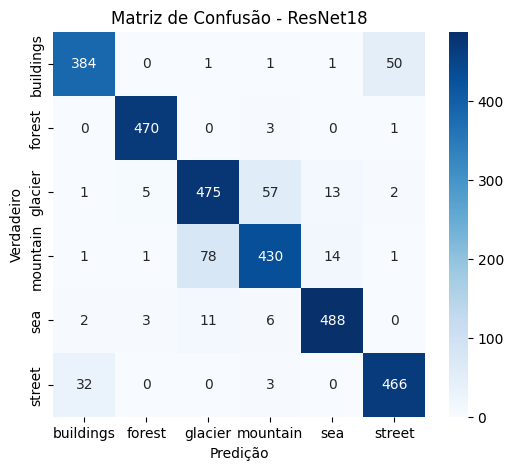

In [19]:
import matplotlib.pyplot as plt

# Matriz de confusão para ResNet
cm_resnet = confusion_matrix(resnet_labels, resnet_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Matriz de Confusão - ResNet18")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.show()


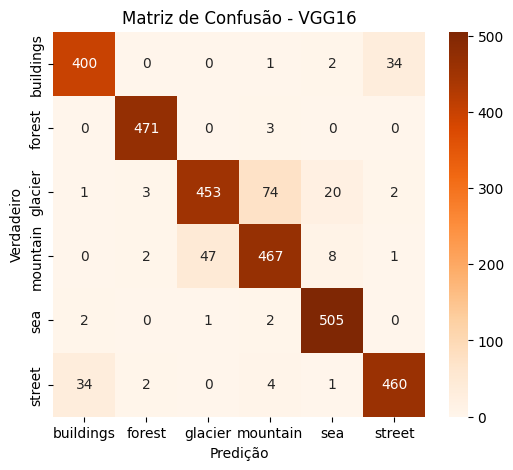

In [20]:
# Matriz de confusão para VGG16
cm_vgg = confusion_matrix(vgg_labels, vgg_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Matriz de Confusão - VGG16")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.show()


In [21]:
# Relatório de classificação - ResNet18
print("Relatório de Classificação - ResNet18:")
print(classification_report(resnet_labels, resnet_preds, target_names=class_names))

# Relatório de classificação - VGG16
print("Relatório de Classificação - VGG16:")
print(classification_report(vgg_labels, vgg_preds, target_names=class_names))


Relatório de Classificação - ResNet18:
              precision    recall  f1-score   support

   buildings       0.91      0.88      0.90       437
      forest       0.98      0.99      0.99       474
     glacier       0.84      0.86      0.85       553
    mountain       0.86      0.82      0.84       525
         sea       0.95      0.96      0.95       510
      street       0.90      0.93      0.91       501

    accuracy                           0.90      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.90      0.90      0.90      3000

Relatório de Classificação - VGG16:
              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.90      0.82      0.86       553
    mountain       0.85      0.89      0.87       525
         sea       0.94      0.99      0.97       510
      street       0.93      0.92      0.92       501

  

## Conclusões

ResNet18 e VGG16 em um cenário de Transfer Learning:

1. Configuração de cada arquitetura (congelamento das camadas iniciais, substituição da camada final).

2. Treinamento (mesma função train_model) para cada modelo, salvando o melhor checkpoint.

3. Avaliação no test set carregando o melhor checkpoint de cada modelo.

4. Comparação de métricas (acurácia, curvas de aprendizado, etc.).

> Isso fornece insights sobre qual modelo se adapta melhor ao dataset e/ou converge mais rapidamente. Ainda podemos:

- Incluir métricas de precisão, recall, F1-score, etc.

- Descongelar camadas adicionais para fine-tuning completo ou parcial.

- Experimentar diferentes otimizadores, taxas de aprendizado, estratégias de scheduler, data augmentation mais elaboradas, etc.

Este Notebook adaptado deve cobrir o cerne da comparação entre ResNet e VGG em Transfer Learning.